In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ================================================================
# 1️⃣ Setup & Device Configuration
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

🚀 Using device: cuda


In [3]:
# ensure 'gdown' is installed so torchvision can download CelebA from Google Drive
%pip install --quiet gdown

dataset = datasets.CelebA(root="./data", split="train", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5]*3, [0.5]*3)
                           ]))

Note: you may need to restart the kernel to use updated packages.


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=34690088-37c4-4b29-bfa6-7bc10548a848
To: c:\Users\dilip\Downloads\lab_expts\DL\data\celeba\img_align_celeba.zip
100%|██████████| 1.44G/1.44G [20:15<00:00, 1.19MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: c:\Users\dilip\Downloads\lab_expts\DL\data\celeba\list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:20<00:00, 1.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: c:\Users\dilip\Downloads\lab_expts\DL\data\celeba\identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:02<00:00, 1.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: c:\Users\dilip\Downloads\lab_expts\DL\data\celeba\list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:04<00:00, 1.26MB/s]


In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

print(f"✅ Loaded {len(dataset)} images for training")

✅ Loaded 162770 images for training


In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# make sure these exist
print(type(model))
print(type(dataloader))
print(device)

<class '__main__.VAE'>
<class 'torch.utils.data.dataloader.DataLoader'>
cuda


In [12]:
EPOCHS = 10
SAVE_DIR = "./vae_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)                 # ✅ move batch to GPU
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)        # forward pass on GPU
        loss = loss_function(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    print(f"Epoch [{epoch}/{EPOCHS}] Loss: {avg_loss:.4f}")

    # --- Save reconstructions ---
    with torch.no_grad():
        sample = imgs[:16]                     # already on GPU
        recon, _, _ = model(sample)
        grid = utils.make_grid(torch.cat([(sample + 1) / 2, (recon + 1) / 2], dim=0), nrow=8)
        utils.save_image(grid, f"{SAVE_DIR}/recon_epoch{epoch}.png")

    # --- Generate new samples ---
    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        gen = model.decode(z)
        utils.save_image((gen + 1) / 2, f"{SAVE_DIR}/sample_epoch{epoch}.png", nrow=8)

print("✅ Training complete! Check the 'vae_outputs' folder for generated images.")


Epoch [1/10] Loss: 845.6613
Epoch [2/10] Loss: 519.2493
Epoch [3/10] Loss: 484.3242
Epoch [4/10] Loss: 462.7143
Epoch [5/10] Loss: 452.3120
Epoch [6/10] Loss: 445.2140
Epoch [7/10] Loss: 439.8298
Epoch [8/10] Loss: 436.4025
Epoch [9/10] Loss: 433.3556
Epoch [10/10] Loss: 431.1793
✅ Training complete! Check the 'vae_outputs' folder for generated images.


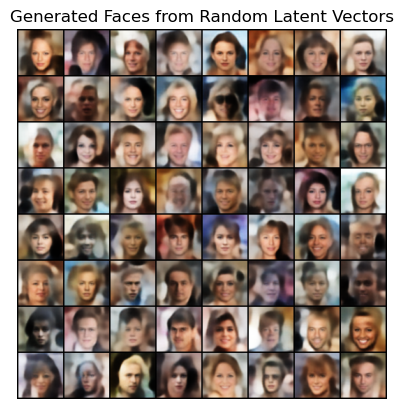

In [13]:
import matplotlib.image as mpimg

latest_sample = f"{SAVE_DIR}/sample_epoch{EPOCHS}.png"
img = mpimg.imread(latest_sample)
plt.imshow(img)
plt.axis("off")
plt.title("Generated Faces from Random Latent Vectors")
plt.show()